# Semana 5: CNN + Transfer Learning
#### Equipo 5:
Jackeline Conant Rubalcava A01280544 \
Javier Eduardo Corrales Cardoza A01742328 \
José Andrés Orantes Guillén A01174130 \
Francisco Salas Porras A01177893 \
Luis Mario Lozoya Chairez A00833364

## Introducción al Notebook

Este notebook tiene como objetivo desarrollar un modelo de red neuronal convolucional aplicando el método de transfer learning. Se usará un dataset de Piedra, papel y tijeras. Este dataset contiene 2,892 imágenes en color de 300x300 píxeles, distribuidas en 3 clases diferentes de manos. El conjunto de entrenamiento consta de 2,520 imágenes y el conjunto de prueba de 372 imágenes.



A lo largo de este notebook, se realizarán las siguientes actividades:

1. **Carga de datos**: Se cargarán los datos del dataset.
2. **Exploración, explicación y limpieza de datos**: Se visualizarán algunas imágenes del conjunto de datos, además se visualizará la estructura de los datos y se prepararán los datos para ser utilizados en el entrenamiento del modelo.
3. **Preprocesamiento de datos**: Se reescalan los datos para que puedan ser procesados por el modelo
4. **Data Agumentation**: Se muestra la configuración de data augmentation que se utilizó.
5. **Transfer Learning**: Se muestra el modelo utilizado para transfer learning.
5. **Construcción del modelo**: Se construirá un modelo de red neuronal convolucional.
6. **Entrenamiento del modelo**: Se entrenará el modelo con los datos de entrenamiento.
7. **Evaluación del modelo**: Se evaluará el rendimiento del modelo utilizando los datos de prueba.
8. **Conclusiones**: Se concluye el tema con reflexiones de los resultados obtenidos

El objetivo final es predecir la categoría de cada categoría a partir de las imágenes proporcionadas y los métodos de data augmentation, utilizando un modelo de red neuronal convolucional.

* Importación de librerías 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model


https://www.tensorflow.org/datasets/catalog/rock_paper_scissors


### Carga de datos

In [3]:
dataset_name = "rock_paper_scissors"

In [4]:
(train_data, test_data), dataset_info = tfds.load(
    name = dataset_name,
    split=['train','test'],
    as_supervised = True,
    with_info= True
)

In [5]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='C:\\Users\\aoran\\tensorflow_datasets\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-data

### Exploración, explicación y limpieza de datos.

In [20]:
x_train, y_train = [], []
x_test, y_test = [], []

# Extract training data
for image, label in tfds.as_numpy(train_data):  # Convert to NumPy for easier manipulation
    x_train.append(image)
    y_train.append(label)

# Extract test data
for image, label in tfds.as_numpy(test_data):
    x_test.append(image)
    y_test.append(label)

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Expande la dimensión de y_train y y_test
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [8]:
print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (2520, 300, 300, 3) (2520, 1)
Testing data shape :  (372, 300, 300, 3) (372, 1)


In [9]:
print(y_train)

[[2]
 [2]
 [0]
 ...
 [1]
 [1]
 [1]]


In [10]:
classes = np.unique(y_train)
num_classes = len(classes)
print('Total number of outputs : ', num_classes)
print('Output classes : ', classes)

Total number of outputs :  3
Output classes :  [0 1 2]


In [23]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

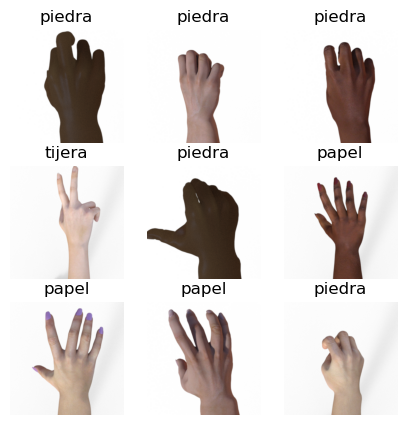

In [11]:
# Definir las etiquetas de las clases
class_names = ['piedra','papel','tijera']

# Seleccionar 9 imágenes aleatorias
indices = np.random.choice(len(x_train), 9, replace=False)
images = x_train[indices]
labels = y_train[indices]

# Crear una cuadrícula de 3x3 para mostrar las imágenes
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i][0]])
    plt.axis('off')
plt.show()

### Transfer Learning

In [12]:
# Definir el número de clases
num_classes = 3  # Cambia esto según tu problema

# Cargar el modelo VGG16 preentrenado sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False



### Construcción del modelo

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2)
])

In [35]:
# Añadir nuevas capas para la nueva tarea de clasificación
x = base_model.output
x = data_augmentation(x)
x = layers.Conv2D(filters=32, kernel_size=1, activation="relu",padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
#x = layers.Dropout(0.25)(x)
predictions = layers.Dense(num_classes, activation="softmax")(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [36]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 9, 9, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,764,259 (56.32 MB)

 Trainable params: 49,507 (193.39 KB)

 Non-trainable params: 14,714,752 (56.13 MB)

In [ ]:

# Guardar el modelo entrenado
#model.save('modelo_transfer_learning.h5')


### Resultados e Interpretación

In [28]:
x_train

array([[[[254, 254, 254],
         [253, 253, 253],
         [254, 254, 254],
         ...,
         [251, 251, 251],
         [250, 250, 250],
         [250, 250, 250]],

        [[254, 254, 254],
         [254, 254, 254],
         [253, 253, 253],
         ...,
         [250, 250, 250],
         [251, 251, 251],
         [249, 249, 249]],

        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [251, 251, 251],
         [250, 250, 250],
         [252, 252, 252]],

        ...,

        [[252, 252, 252],
         [251, 251, 251],
         [252, 252, 252],
         ...,
         [247, 247, 247],
         [249, 249, 249],
         [248, 248, 248]],

        [[253, 253, 253],
         [253, 253, 253],
         [251, 251, 251],
         ...,
         [248, 248, 248],
         [248, 248, 248],
         [248, 248, 248]],

        [[252, 252, 252],
         [253, 253, 253],
         [252, 252, 252],
         ...,
         [248, 248, 248],
        

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.2)  

Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.6693 - loss: 0.8066 - val_accuracy: 0.9782 - val_loss: 0.0934
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.9351 - loss: 0.1863 - val_accuracy: 0.9940 - val_loss: 0.0159
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.9725 - loss: 0.0971 - val_accuracy: 0.9921 - val_loss: 0.0189


In [38]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Pérdida en test: {test_loss}, Precisión en test: {test_acc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9086 - loss: 0.2925
Pérdida en test: 0.3146904706954956, Precisión en test: 0.9032257795333862


### Conclusiones